# CSK Extrapolation Evaluation

In [1]:
import os
os.chdir("../")
from dice.evaluation import Tracker
from dice import Inputs
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib2tikz
import itertools

/home/ychalier/anaconda3/envs/dice/lib/python3.6/site-packages/matplotlib2tikz/__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


## 1. Gathering Data for Annotation

In [2]:
INPUT_FOLDER = "scratch/conceptnet"
DUMMY_FOLDER = "scratch/conceptnet/dummy"
AGGREGATE_TRACKER_PATH = "out/aggregated_tracker.tsv"
ANNOTATION_INPUT_PATH_1 = "out/dummy_facts_v1.csv"
ANNOTATION_INPUT_PATH_2 = "out/dummy_facts_v2.csv"

Grouping facts by subjects.

In [3]:
known = dict()
for fact in Inputs(INPUT_FOLDER).get_kb().values():
    known.setdefault(fact.subject, 0)
    known[fact.subject] += 1

Aggregating results into one big tracker.

In [4]:
aggregated_tracker = Tracker()
total = 0
for dir_entry in os.scandir(DUMMY_FOLDER):
    tracker_path = os.path.join(dir_entry.path, "tracker.tsv")
    if os.path.isfile(tracker_path):
        dummy_tracker = Tracker(tracker_path)
        print(
            "Found",
            len(dummy_tracker),
            "new facts about",
            "'" + dir_entry.name + "'",
            "which had",
            known[dir_entry.name]
        )
        total += known[dir_entry.name]
        for fact in dummy_tracker.values():
            fact.index = len(aggregated_tracker) + 1
            aggregated_tracker[fact.index] = fact

# Uncomment to output
# aggregated_tracker.save(AGGREGATE_TRACKER_PATH)

Found 2209 new facts about 'park' which had 13
Found 834 new facts about 'sculpture' which had 11
Found 0 new facts about 'letterboxes' which had 1
Found 2544 new facts about 'magnet' which had 11
Found 1984 new facts about 'saddle' which had 28
Found 0 new facts about 'motorist' which had 1
Found 0 new facts about 'pipette' which had 1
Found 0 new facts about 'thursday' which had 1
Found 0 new facts about 'sportscar' which had 1
Found 0 new facts about 'velociraptor' which had 3
Found 3969 new facts about 'tapestry' which had 27
Found 4546 new facts about 'athlete' which had 48
Found 0 new facts about 'chapter' which had 4


Sampling tracker.

In [5]:
def group(facts, out_path, size):
    random.shuffle(facts)
    r = len(facts) % size
    if r != 0:
        facts += facts[:size-r]
    data = list()
    for i in range(0, len(facts), size):
        data.append(list())
        for j in range(size):
            data[i // size] += facts[i + j]
    with open(out_path, "w") as file:
        for i in range(size):
            if i > 0:
                file.write(",")
            file.write("index_{i},source_{i},subject_{i},property_{i}".format(i=i))
        file.write("\n")
        for row in data:
            file.write(",".join(row) + "\n")

indices = list(random.sample(aggregated_tracker.keys(), 100))
sampled_facts = list()
for index in indices:
    sampled_facts.append([
        str(aggregated_tracker[index].index),
        aggregated_tracker[index].source,
        aggregated_tracker[index].subject,
        aggregated_tracker[index].property,
    ])
    
# Uncomment to output
# group(sampled_facts, ANNOTATION_INPUT_PATH_1, 4)

Second annotation task, for top-ranked facts.

In [6]:
to_annotate = set()
for dim in range(4):
    indices = sorted(
        aggregated_tracker,
        key=lambda i: -aggregated_tracker[i].attributes[dim]["confidence"]
    )
    expansion = list()
    precision = list()
    for i, index in enumerate(indices):
        if i > total * 10:
            break
        if i < 200 and i % 7 == 0:
            to_annotate.add(indices[i])
        elif i % 20 == 0:
            to_annotate.add(indices[i])
    
to_annotate = [index for index in to_annotate if index not in indices]
print("Need to annotate", len(to_annotate), "more facts.")

sampled_facts = list()
for index in to_annotate:
    sampled_facts.append([
        str(aggregated_tracker[index].index),
        aggregated_tracker[index].source,
        aggregated_tracker[index].subject,
        aggregated_tracker[index].property,
    ])

# Uncomment to output
# group(sampled_facts, ANNOTATION_INPUT_PATH_2, 4)

Need to annotate 0 more facts.


## 2. Gathering Annotations

In [7]:
ANNOTATIONS = [
    "data/annotation/answer/Batch_3735107_batch_results.csv",
    "data/annotation/answer/Batch_3736138_batch_results.csv"
]

Aggregating annotations.

In [8]:
data = list()
for path in ANNOTATIONS:
    df = pd.read_csv(path)
    for index, row in df.iterrows():
        for i in range(4):
            data.append({
                "index": row["Input.index_" + str(i)],
                "plausible": row["Answer.plausible" + str(i)]
        })
df = pd.DataFrame(data).groupby("index").mean().sort_values(by="plausible")

In [9]:
series = dict()
for dim in range(4):
    indices = sorted(aggregated_tracker, key=lambda i: -aggregated_tracker[i].attributes[dim]["confidence"])
    expansion = list()
    precision = list()
    errors = list()
    buffer = list()
    for i, index in enumerate(indices):
        if index in df.index:
            buffer.append(df.loc[index]["plausible"])
        if len(buffer) > 0:
            expansion.append((i + 1) / total)
            precision.append(sum(buffer) / len(buffer))
            errors.append((1 / len(buffer) ** .5))
    series[["Plausible", "Typical", "Remarkable", "Salient"][dim]] = {
        "x": expansion[:],
        "y": precision[:],
        "err": errors[:],
    }

## 3. Results

In [10]:
PLAUSIBILITY_ANNOTATION_PATH = "data/annotation/answer/Batch_3721563_batch_results.csv"
TEX_OUTPUT_PATH = "dummy-plot.tex"

Getting baseline score from previous Plausiblity annotation.

In [11]:
mean = pd.read_csv(PLAUSIBILITY_ANNOTATION_PATH).mean()[[
    "Answer.plausible0",
    "Answer.plausible1",
    "Answer.plausible2",
    "Answer.plausible3"
]].mean()

/home/ychalier/anaconda3/envs/dice/lib/python3.6/site-packages/matplotlib2tikz/axes.py:508: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  major_ticks_bottom = [tick.tick1On for tick in major_ticks]
/home/ychalier/anaconda3/envs/dice/lib/python3.6/site-packages/matplotlib2tikz/axes.py:509: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.get_visible instead.
  major_ticks_top = [tick.tick2On for tick in major_ticks]


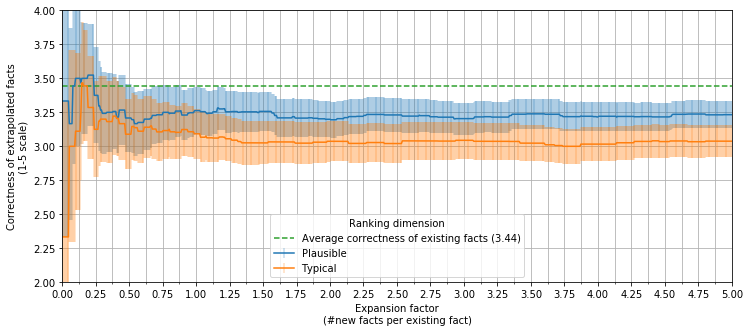

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
markers = itertools.cycle(["s", "*", "v", "o"])
for label, coords in series.items():
    if label in ["Salient", "Remarkable"]:
        continue
    marker = next(markers)
    ax.errorbar(
        coords["x"][:800],
        coords["y"][:800],
        yerr=coords["err"][:800],
        label=label,
        linewidth=1.5,
        linestyle="-",
        elinewidth=.4,
    )
ax.plot(
    range(11),
    [mean for _ in range(11)],
    label="Average correctness of existing facts (3.44)",
    linestyle="--"
)
ax.grid()
ax.legend(title="Ranking dimension", loc="lower center")
ax.xaxis.set_ticks([i / 4 for i in range(5 * 4 + 1)])
ax.xaxis.set_ticks([i / 4 + .125 for i in range(5 * 4 )], minor=True)
ax.xaxis.grid(True, which="minor")
ax.set_xlabel("Expansion factor\n(#new facts per existing fact)")
ax.set_ylabel("Correctness of extrapolated facts\n(1-5 scale)")
ax.set_xlim(0, 5)
ax.set_ylim(2, 4)
matplotlib2tikz.save(TEX_OUTPUT_PATH)
pass

In [13]:
for dim in range(2):
    print("-"*80)
    print("Top", ["Plausible", "Typical"][dim])
    print("-"*80)
    indices = sorted(aggregated_tracker, key=lambda i: -aggregated_tracker[i].attributes[dim]["confidence"])
    for i, index in enumerate(indices[:20]):
        print(i+1, "\t", aggregated_tracker[index].subject, "\t", aggregated_tracker[index].property)
    print("\n")

--------------------------------------------------------------------------------
Top Plausible
--------------------------------------------------------------------------------
1 	 park 	 be use when it dark
2 	 park 	 wants to blue sky and warm day
3 	 sculpture 	 be at art in museum
4 	 sculpture 	 be silver or gold in color
5 	 magnet 	 be at any big north american city
6 	 saddle 	 wants to go on vacation in beautiful place
7 	 tapestry 	 be used to cool off on hot day
8 	 athlete 	 be one of favourite american sport
9 	 athlete 	 wants to play competitive game
10 	 magnet 	 be at in fridge
11 	 sculpture 	 be at art museum
12 	 sculpture 	 be at art in art museum
13 	 magnet 	 be at in refrigerator
14 	 athlete 	 be win in sport
15 	 magnet 	 has fridge
16 	 saddle 	 be used to ride horse
17 	 magnet 	 be at your refrigerator
18 	 magnet 	 be store in fridge
19 	 magnet 	 be at refrigerator freezer
20 	 sculpture 	 be see in museum


------------------------------------------------